<a href="https://colab.research.google.com/github/EirafWali/Supervised_Wells_ML/blob/main/Supervised_Wells_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised ML: Well logs prediction

Source: https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition

About the dataset: This dataset contains well logs that were used in a competition in 2020 to predict the lithology.

In this notebook, I will use the same dataset (logs) to try and predict the desnity log.
- Idea : Use the logs las files, filter wells with full sets of logs, hide the density log, and try to predict it using the other logs.

Methodology:
- Hide the density log.
- Maybe use the linear regression.
- Use the (Porosity, GR, Sonic) logs in order to train the model and predict the missing log.

Importance:
- This work is useful when there are missing logs. Can be used in research or even in the industry if it worked.

### Section 1: Loading and Cleaning the Dataset

In [2]:
!pip install requests lasio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 4.0 MB/s eta 0:00:00


In [3]:
# Import needed libraries
import os
import pandas as pd
import requests
import lasio
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Read the Las files from Github repository

# GitHub repo details
repo_url = "https://api.github.com/repos/EirafWali/Supervised_Wells_ML/contents/las_files"
local_directory = "las_files"

# Create a local folder
os.makedirs(local_directory, exist_ok=True)

# Requests the files fromgithub and checks if that was successful (200=success)
response = requests.get(repo_url)
if response.status_code != 200:
    raise Exception("Failed to fetch LAS files from GitHub")

# Only get the LAS files
las_file_urls = [file["download_url"] for file in response.json() if file["name"].endswith(".las")]

# Download and save the LAS files
for url in las_file_urls:
    filename = os.path.join(local_directory, os.path.basename(url))
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        with open(filename, 'wb') as f:
            f.write(requests.get(url).content)
    else:
        print(f"{filename} already exists.")

# Read and print LAS files and the number of curves
for filename in os.listdir(local_directory):
    if filename.endswith(".las"):
# Add a try-except block to handle potential errors
        try:
            las = lasio.read(os.path.join(local_directory, filename))
            print(f"Loaded {filename} with {len(las.curves)} curves.")
        except KeyError as e:
            print(f"Error reading {filename}: {e}")


Loaded 25_5-4.las with 21 curves.
Loaded 34_10-33.las with 17 curves.
Loaded 35_11-11.las with 22 curves.
Loaded 35_3-7%20S.las with 21 curves.
Loaded 35_11-6.las with 19 curves.
Loaded 34_8-1.las with 21 curves.
Loaded 34_2-4.las with 19 curves.
Loaded 31_3-2.las with 21 curves.
Loaded 35_11-5.las with 19 curves.
Loaded 31_2-7.las with 20 curves.
Error reading 35_9-2.las: 'No ~ sections found. Is this a LAS file?'
Loaded 35_11-13.las with 21 curves.
Loaded 34_7-21.las with 18 curves.
Error reading 35_9-10%20S.las: 'No ~ sections found. Is this a LAS file?'
Loaded 16_1-6%20A.las with 18 curves.
Loaded 31_2-19%20S.las with 23 curves.
Error reading 34_4-10%20R.las: 'No ~ sections found. Is this a LAS file?'
Loaded 34_8-7%20R.las with 18 curves.
Loaded 35_6-2%20S.las with 20 curves.
Loaded 35_11-10.las with 21 curves.
Error reading 35_9-7.las: 'No ~ sections found. Is this a LAS file?'
Loaded 16_1-2.las with 20 curves.
Error reading 34_6-1%20S.las: 'No ~ sections found. Is this a LAS file

Note that there were some errors in reading the data.
The next code deletes any problematic las files

In [5]:
# This code will remove the problematic las files from the dataset

local_directory = "las_files"

# Loop through all LAS files
for filename in os.listdir(local_directory):
    if filename.endswith(".las"):
        filepath = os.path.join(local_directory, filename)

        try:
            # Try reading the LAS file
            las = lasio.read(filepath)
        except Exception as e:
            # If there's an error, delete the file
            print(f"Deleting {filename} due to error: {e}")
            os.remove(filepath)

print("Clean-up complete. All problematic LAS files have been deleted.")


Deleting 35_9-2.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 35_9-10%20S.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 34_4-10%20R.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 35_9-7.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 34_6-1%20S.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 7_1-1.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 34_7-13.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 34_3-3%20A.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 35_9-6%20S.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 34_5-1%20S.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 35_9-8.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 35_9-5.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 34_5-1%20A.las due to error: 'No ~ sectio

In [6]:
# Count the number of LAS files in the directory
las_files = [file for file in os.listdir(local_directory) if file.endswith(".las")]
total_wells = len(las_files)

print(f"Total number of wells: {total_wells}")

Total number of wells: 104


In [7]:
# Create a dataframe with all the wells for easier coding and analysis

# dataframe to store individual wells
dfs = []

# Loop through each LAS file
for filename in os.listdir(local_directory):
    if filename.endswith(".las"):
        filepath = os.path.join(local_directory, filename)

        try:
            # Read the LAS file
            las = lasio.read(filepath)

            # Convert LAS data to a dataframe
            df = las.df()

            # Add a 'Well' column to keep track of which well the data came from
            df['Well'] = os.path.splitext(filename)[0]  # Use the filename as the well name

            # Append this well's data to the list
            dfs.append(df)

        except Exception as e:
            print(f"Skipping {filename} due to error: {e}")

# Combine all DataFrames into one
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"Combined DataFrame shape: {combined_df.shape}")
    print(combined_df.head())
else:
    print("No valid wells were processed.")

Combined DataFrame shape: (2034847, 27)
   FORCE_2020_LITHOFACIES_CONFIDENCE  FORCE_2020_LITHOFACIES_LITHOLOGY  CALI  \
0                                NaN                               NaN   NaN   
1                                NaN                               NaN   NaN   
2                                NaN                               NaN   NaN   
3                                NaN                               NaN   NaN   
4                                NaN                               NaN   NaN   

     BS  DCAL  RDEP  RSHA  RMED  RXO  SP  ...  X_LOC  Y_LOC  Z_LOC    Well  \
0  36.0   NaN   NaN   NaN   NaN  NaN NaN  ...    NaN    NaN    NaN  25_5-4   
1  36.0   NaN   NaN   NaN   NaN  NaN NaN  ...    NaN    NaN    NaN  25_5-4   
2  36.0   NaN   NaN   NaN   NaN  NaN NaN  ...    NaN    NaN    NaN  25_5-4   
3  36.0   NaN   NaN   NaN   NaN  NaN NaN  ...    NaN    NaN    NaN  25_5-4   
4  36.0   NaN   NaN   NaN   NaN  NaN NaN  ...    NaN    NaN    NaN  25_5-4   

   ROPA  R

In [8]:
# Checking the new combined dataframe

# Printing length of the dataset to check if it matches the requirement for the course.
print('The total number of rows and columns of the dataset are:', combined_df.shape, 'respectively')

# Prinitng the descriptive statistics of the DataFrame
combined_df.describe()

The total number of rows and columns of the dataset are: (2034847, 27) respectively


,FORCE_2020_LITHOFACIES_CONFIDENCE,FORCE_2020_LITHOFACIES_LITHOLOGY,CALI,BS,DCAL,RDEP,RSHA,RMED,RXO,SP,...,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,ROPA,ROP,RMIC,DTS,SGR,MUDWEIGHT
count,1.325457e+06,1.314095e+06,1.330284e+06,1.189227e+06,353401.000000,1.932683e+06,832275.000000,1.811010e+06,384015.000000,1.186549e+06,...,1.935352e+06,1.935352e+06,1.935352e+06,1.935352e+06,515472.000000,1.006239e+06,201305.000000,291467.000000,65611.000000,423976.000000
mean,1.154621e+00,6.131842e+04,1.341096e+01,1.362552e+01,17.776025,9.186921e+00,10.300375,4.492815e+00,-101.475557,4.119648e+01,...,1.888031e+03,4.836164e+05,6.679755e+06,-1.849435e+03,40.442103,3.888074e+02,9.870976,225.697666,58.837939,7.838251
std,4.326097e-01,1.422512e+04,3.760621e+00,4.945673e+00,411.060253,9.668357e+01,98.742017,5.639942e+01,365.048497,1.712451e+02,...,1.041510e+03,3.502818e+04,1.317632e+05,1.025200e+03,100.540619,3.326489e+03,115.639926,86.288349,52.830631,34.623737
min,1.000000e+00,3.000000e+04,2.340806e+00,6.000000e+00,-23.199656,1.000000e-04,0.000100,-8.418695e-03,-999.900024,-4.498991e+03,...,9.872000e+01,4.232375e+05,6.429286e+06,-5.435889e+03,-999.250122,-1.179770e-01,0.056586,69.163177,-983.000000,0.124619
25%,1.000000e+00,6.500000e+04,1.031984e+01,9.875000e+00,0.088883,9.218598e-01,0.846616,8.970848e-01,0.660044,2.782677e+01,...,1.044184e+03,4.544695e+05,6.563688e+06,-2.569990e+03,15.888569,9.841293e+00,0.791571,159.800972,38.511086,0.140197
50%,1.000000e+00,6.500000e+04,1.266149e+01,1.225000e+01,0.460175,1.408167e+00,1.367638,1.359781e+00,1.326799,5.204029e+01,...,1.768046e+03,4.763136e+05,6.738647e+06,-1.735255e+03,26.960051,2.457847e+01,1.575975,201.777756,65.645340,0.155774
75%,1.000000e+00,6.500000e+04,1.703239e+01,1.750000e+01,1.233560,2.328961e+00,2.678929,2.252276e+00,3.129159,7.677947e+01,...,2.608848e+03,5.183636e+05,6.784873e+06,-1.018491e+03,40.343411,4.288836e+01,3.792285,269.575043,84.258865,1.126368
max,3.000000e+00,9.900000e+04,3.211106e+01,4.200000e+01,10023.759766,1.999997e+03,2193.904541,1.999948e+03,35930.671875,5.265473e+02,...,5.477672e+03,5.726328e+05,6.856661e+06,-7.265216e+01,3989.174316,9.242916e+04,10000.000000,724.536194,963.608582,426.921356


In [9]:
# Check for NaN values in the DataFrame
nan_counts = combined_df.isna().sum()
nan_counts


,0
FORCE_2020_LITHOFACIES_CONFIDENCE,709390
FORCE_2020_LITHOFACIES_LITHOLOGY,720752
CALI,704563
BS,845620
DCAL,1681446
RDEP,102164
RSHA,1202572
RMED,223837
RXO,1650832
SP,848298


Note: We can see that there are many rows with Nans or empty rows.
The next code will focus on cleaning the important columns (GR,RHOB,NPHI,DTC,CALI,DTS)

In [10]:
# Drop rows where NaNs exist only in the columns of interest
cleaned_df = combined_df.dropna(subset=['GR', 'RHOB','NPHI','DTC','CALI','DTS','DEPTH_MD'])

# Check the length after cleaning
print(f"Shape of the DataFrame after specific NaN cleanup: {cleaned_df.shape}")

Shape of the DataFrame after specific NaN cleanup: (208391, 27)


In [11]:
# Remove un-needed logs
cleaned_df = cleaned_df.drop(columns=['ROPA', 'MUDWEIGHT','DRHO','SGR','ROP','DCAL','RXO','PEF','RSHA',
                                      'RMED','BS','RMIC','FORCE_2020_LITHOFACIES_CONFIDENCE','FORCE_2020_LITHOFACIES_LITHOLOGY'])

# Display the updated column list
cleaned_df.columns


Index(['CALI', 'RDEP', 'SP', 'DTC', 'NPHI', 'GR', 'RHOB', 'DEPTH_MD', 'X_LOC',
       'Y_LOC', 'Z_LOC', 'Well', 'DTS'],
      dtype='object')

After removing the Nan rows, more cleaning to do includes: checking for negative density values to remove it or porosities more than 100% as these values don't make sense

In [12]:
# This code checks for values that does not make sense in the  density column.

# Check rows where RHOB is negative
negative_RHOB = cleaned_df[cleaned_df['RHOB'] < 0]

# Display the results
if negative_RHOB.empty:
    print("No negative values found in the density log.")
else:
    print(f"Number of negative density values: {len(negative_RHOB)}")
    print(negative_RHOB)

No negative values found in the density log.


In [13]:
# Check for porosity values outside the valid range (negative or greater than 1)
invalid_poro = cleaned_df[(cleaned_df['NPHI'] < 0) | (cleaned_df['NPHI'] > 1)]

# Display results
if invalid_poro.empty:
    result = "All porosity values are within the valid range (0 to 1)."
else:
    result = (f"Number of invalid porosity values: {len(invalid_poro)}", invalid_poro[['DEPTH_MD', 'NPHI']].head(5))

result

('Number of invalid porosity values: 70',
             DEPTH_MD      NPHI
 1848748  2136.107910 -0.006748
 1848749  2136.260010 -0.004603
 1848750  2136.412109 -0.001754
 1848751  2136.563965 -0.000304
 1848752  2136.716064 -0.001022)

In [14]:
# Drop rows where porosity values are invalid
cleaned_df = cleaned_df[(cleaned_df['NPHI'] >= 0) & (cleaned_df['NPHI'] <= 1)]

# Display the shape of the cleaned DataFrame
cleaned_df_shape = cleaned_df.shape
cleaned_df_shape


(208321, 13)

In [15]:
cleaned_df.describe()

,CALI,RDEP,SP,DTC,NPHI,GR,RHOB,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,DTS
count,208321.000000,208321.000000,58408.000000,208321.000000,208321.000000,208321.000000,208321.000000,208321.000000,208321.000000,2.083210e+05,208321.000000,208321.000000
mean,10.894045,3.916076,3.586963,99.691553,0.312910,85.884675,2.409692,2634.947771,497956.039469,6.699213e+06,-2578.227639,214.936531
std,2.429947,14.055128,121.779542,23.541238,0.121004,41.039277,0.173474,881.912481,34548.293208,1.380897e+05,868.633484,87.357842
min,3.336693,0.123068,-234.316742,44.967892,0.000146,1.089321,1.244665,1107.875244,433906.843750,6.429287e+06,-4889.455566,81.695892
25%,8.587626,1.190750,-108.205593,82.071396,0.225014,58.337708,2.298061,1937.627686,463953.781250,6.552700e+06,-3165.107178,152.315155
50%,12.004746,1.867771,51.230047,94.118866,0.312149,85.565773,2.442724,2475.520752,499935.656250,6.765246e+06,-2418.804443,187.088318
75%,12.562795,3.478405,76.937704,112.598885,0.392715,104.741608,2.544008,3206.992432,525325.562500,6.822398e+06,-1891.942261,244.006775
max,22.675938,1596.285523,197.647049,178.817993,0.993175,1141.292114,3.213747,4926.972168,572632.750000,6.856661e+06,-1081.842651,724.536194


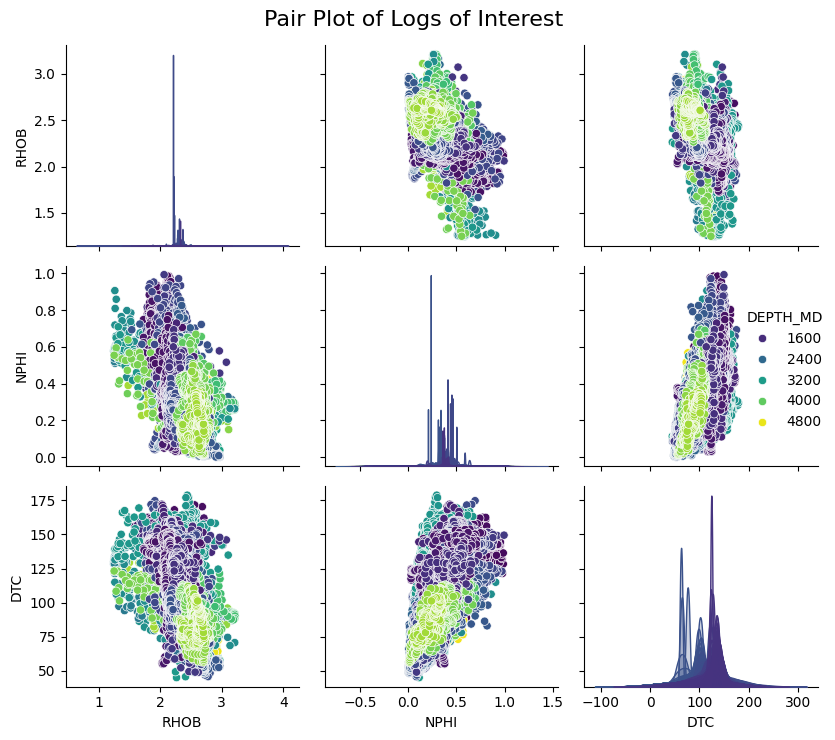

In [16]:
# Figure 1:

# Create a pair plot for the logs of interest to understand the realtionsips between them
sns.pairplot(
    cleaned_df,
    vars=['RHOB', 'NPHI', 'DTC'],       # Data columns to include
    hue= 'DEPTH_MD',                      # Color the points by the depth
    palette='viridis'                 # Specify color palette
)

# Add title
plt.suptitle('Pair Plot of Logs of Interest', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

### Figure 1:

The Pair plot Shows the relationships between the RHOB, NPHI, and DTC logs. The points are color-coded by depth.

- The RHOB vs. NPHI plot shows an expected inverse relationship, where higher porosity corresponds to lower density.

- The RHOB vs. DTC plot shows another inverse relationship, where lower DTC values (faster wave travel time ) correspond to denser rocks with higher RHOB. In contrast, higher DTC values are linked to less dense, porous formations. This relationship aligns with the behavior of compressional waves, which travel faster through compact, denser materials and slower through porous or fluid-filled formations.

- The NPHI vs. DTC plot shows a clear trend where higher porosities correlates with higher sonic travel times, indicating slower travel times in porous formations. As depth increases, we see a transition toward more compact, stiffer formations (yellow and green), with tighter clustering of data points at lower porosities and lower DTC values.




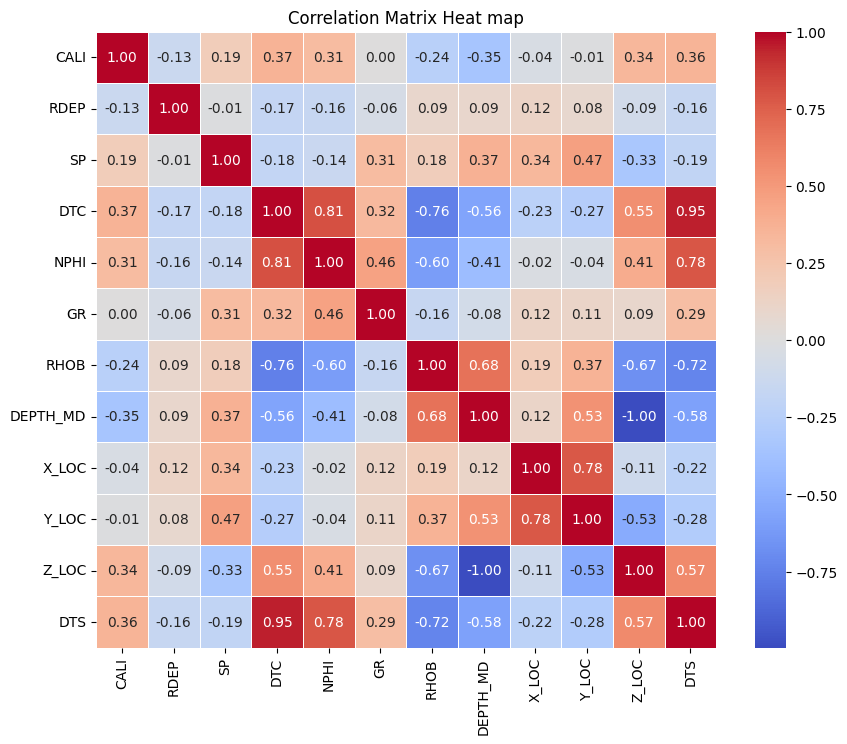

In [17]:
# Figure 2:
# This code box is to plot a correlation matrix heat map of the dataset

# Correlation matrix for numeric columns only
correlation_matrix = cleaned_df.select_dtypes(include=['number']).corr() # Select only numeric columns for correlation

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,  # Display correlation values
    cmap='coolwarm',  # Color palette
    fmt='.2f',  # Format for the numbers
    linewidths=0.5  # Line width between cells
)

# Add a title
plt.title("Correlation Matrix Heat map")

# Display the plot
plt.show()

### Figure 2: Correlation matrix heat map


The Correlation heatmap shows the relationships between the well logs, spatial coordinates, and depth.

- There are some strong negative correlations observed between DTC and RHOB (-0.76), as well as DTS and RHOB (-0.72), indicating that denser formations correspond to faster sonic wave velocities.

- The DTS and DTC have a high positive correlation (0.95) which is expected and it shows their complementary role in capturing wave propagation.

- NPHI and DTC show a strong positive correlation (0.81), suggesting that higher porosities slows down the propagation of waves.

- Depth is moderately correlated with RHOB (0.68), reflecting the trend of increasing compaction with depth.

The next plot is a histogram to see the distibution of the logs data points.

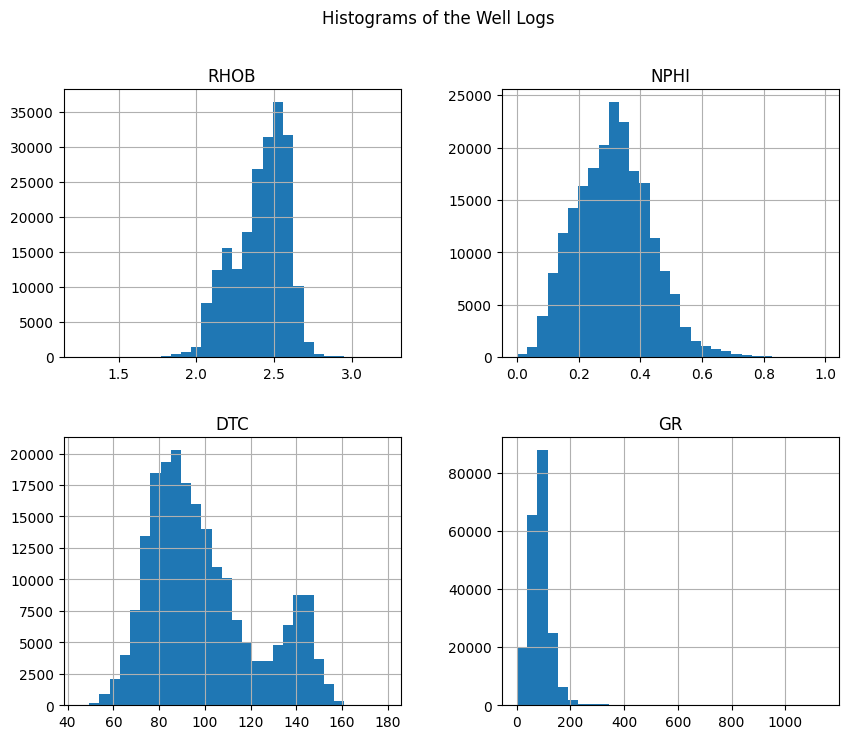

In [18]:
# Figure 3: Plotting Histograms

cleaned_df[['RHOB', 'NPHI', 'DTC', 'GR']].hist(bins=30, figsize=(10, 8), layout=(2, 2))
plt.suptitle('Histograms of the Well Logs')
# Display the plot
plt.show()

### Figure 3: Histograms of The Well Logs

The plot shows the Histograms of well logs of interest (RHOB, NPHI, DTC, and GR) showing their distributions which can help to identify lithologies, porosity ranges, and sonic travel times within the subsurface.

- The RHOB histogram shows that most density values lie between 2.0 and 2.8 g/cm³, with a strong peak around 2.5 g/cm³. This indicates the presence of common subsurface formations such as sandstones, shales, and carbonates. The small tail toward lower densities of approximately 1.2-1.5 g/cm³ could indicate coal bed zones. This matches our domain knowledge as we know that 33% of the data is coal beds.

- The NPHI histogram shows that most porosity values range between 0.2 and 0.4, which is typical of moderate to highly porous formations like sands and porous limestones. A significant right tail extends beyond 0.6, suggesting zones of high porosity, which could correspond to unconsolidated sands.

- The DTC histogram shows that most compressional travel times lie between 60 and 140 μs/ft, with a peak around 80-100 μs/ft. This range suggests the presence of moderately compacted formations where wave velocities are typical of shales and sandstones. However, the right tail, extending beyond 150 μs/ft, may correspond to high-porosity zones or unconsolidated formations where wave propagation is slower due to fluid-filled pores.

- The GR histogram shows a peak around 50-150 API, suggesting that the dataset contains a significant proportion of clean formations like sands. The long tail toward higher values, exceeding 600 API, indicates the presence of shale or clay-rich formations, which are typically more radioactive due to their clay and mineral content.

The next code block is to plot the first well's logs to see how they look like

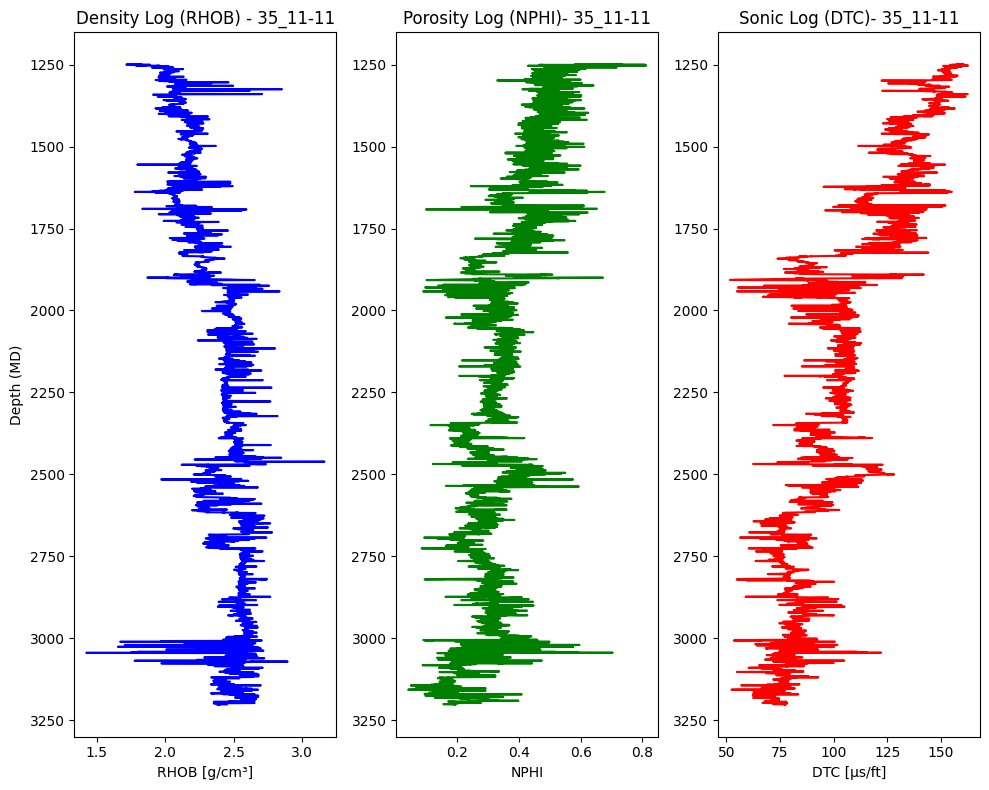

In [19]:
# Figure 4:  Well logs for the first well in the list

# Filter for the first well
well_name = cleaned_df['Well'].unique()[0]  # Select the first well
well_data = cleaned_df[cleaned_df['Well'] == well_name]

# Plot multiple logs vs. depth for the selected well
plt.figure(figsize=(10, 8))

# Plot Density
plt.subplot(1, 3, 1)
plt.plot(well_data['RHOB'], well_data['DEPTH_MD'], color='blue')
plt.gca().invert_yaxis()  # Depth increases downward
plt.xlabel('RHOB [g/cm³]')
plt.ylabel('Depth (MD)')
plt.title(f'Density Log (RHOB) - {well_name}')

# Plot Neutron Porosity
plt.subplot(1, 3, 2)
plt.plot(well_data['NPHI'], well_data['DEPTH_MD'], color='green')
plt.gca().invert_yaxis()
plt.xlabel('NPHI')
plt.title(f'Porosity Log (NPHI)- {well_name}')

# Plot Sonic Travel Time
plt.subplot(1, 3, 3)
plt.plot(well_data['DTC'], well_data['DEPTH_MD'], color='red')
plt.gca().invert_yaxis()
plt.xlabel('DTC [μs/ft]')
plt.title(f'Sonic Log (DTC)- {well_name}')

# Display the logs
plt.tight_layout()
plt.show()

### Figure 4: Well logs for the first well in the list (35_11-11)

the figure plots the density, porosity, and sonic logs respetively.
We plotted a random well to visualize the data and check if there are any issues with the points after the cleaning.
the logs look good and with no issues. which confirms that the cleaning process was sufficient until this step.